## Imports

In [1]:
import os
print(os.getcwd())

/public.hpc/federico.spurio


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random as rand

KeyboardInterrupt: 

In [ ]:
# RUN THIS CODE ONLY ON REMOTE JUPYTER NOTEBOOK
import sys
sys.path.append('./deepcriminalfiles/')

In [3]:
from deepface import DeepFace

Fix randomicity

In [3]:
seed = 42
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()
tf.random.set_seed(seed)
np.random.seed(seed)
rand.seed(seed)

Check if notebook run on GPU

In [4]:
print(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# print("\n")
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


## Tensorboard

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/fit

# Load Dataset

In [5]:
batch_size = 4
image_size = (152, 152)
train_val_split = 0.2
data_dir = "./dataset/distributed/" # "Mugshots/front/aligned/" "./deepcriminalfiles/dataset/little/"

In [6]:
criminal_train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=train_val_split,
    subset='training',
    seed=seed,
    image_size=image_size,
    batch_size=batch_size
)

criminal_val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=train_val_split,
    subset='validation',
    seed=seed,
    image_size=image_size,
    batch_size=batch_size
)

Found 3912 files belonging to 2 classes.
Using 3130 files for training.
Found 3912 files belonging to 2 classes.
Using 782 files for validation.


## DeepFace model

In [7]:
for b in criminal_train_ds.take(1):
    img_array = tf.expand_dims(b[0][0], axis=0)
    break

In [ ]:
model = DeepFace()
optimizer = tf.keras.optimizers.SGD()  # TODO: try another optimizer
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer, loss, metrics=['accuracy'])
model.call(inputs=img_array)
model.build(input_shape=(4,152,152,3))

In [ ]:
model.summary()

In [ ]:
model.summary_model()

In [ ]:
from datetime import datetime
from keras.callbacks import History, EarlyStopping, ModelCheckpoint

history = History()
log_dir = "logs/model_" + datetime.now().strftime("%Y%m%d-%H%M%S") 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir) # , histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=10)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min', restore_best_weights=True)
# mcp_save = ModelCheckpoint('./models/deepface.hdf5', save_best_only=True, monitor='val_loss', mode='min')

callbacks = [history, early_stopping, tensorboard_callback]

In [ ]:
model.fit(criminal_train_ds, validation_data=criminal_val_ds, epochs=10, use_multiprocessing=True, workers=8, callbacks=callbacks)  # .take(20)

In [ ]:
model.save_weights('./models/distributed_deepface_best.h5')

### Explainability

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
model_builder = keras.applications.xception.Xception
img_size = (152, 152) # (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = 'L6' # "block14_sepconv2_act"

# The local path to our target image
# img_path = keras.utils.get_file(
#     "african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
# )

# display(Image(img_path))

In [ ]:
a = tf.convert_to_tensor([[0.5]])
np.array(a)

In [ ]:
tf.executing_eagerly()

In [9]:
from deepface import DeepFaceCross

model = DeepFaceCross()
optimizer = tf.keras.optimizers.SGD()  # TODO: try another optimizer
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer, loss, metrics=['accuracy'])
model.call(inputs=img_array)
model.build(input_shape=(4,152,152,3))

In [ ]:
inputs = keras.layers.Input(shape=(152,152,3))
outputs = model.call(inputs)
m3 = tf.keras.Model(inputs=inputs, outputs=outputs, name='DeepFace')

In [ ]:
m3.load_weights('./models/distributed_deepface_best.h5')

In [ ]:
m3.summary()

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [14]:
img_t = 0
for b in criminal_train_ds.take(1):
    img_t = tf.expand_dims(b[0][0], axis=0)
    print(b[1][0])
    break

print(img_t.shape)

tf.Tensor(0, shape=(), dtype=int32)
(1, 152, 152, 3)


In [19]:
nc = 0
for b in criminal_train_ds.take(1):
    for i, val in enumerate(b[1]):
        if val == 1:
            nc = tf.expand_dims(b[0][i], axis=0)
            print(b[1][i])
            break

tf.Tensor(1, shape=(), dtype=int32)


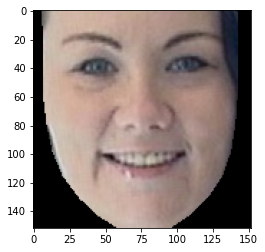

In [15]:
plt.figure()
plt.imshow(tf.cast(img_t[0], tf.uint32))
plt.show()

In [ ]:
m3.predict(nc)

In [ ]:
last_conv_layer_name = 'L6'

In [ ]:
# Prepare image
img_array = preprocess_input(nc)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, m3, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image

    # img = keras.preprocessing.image.load_img(img_path)
    # img = keras.preprocessing.image.img_to_array(img)
    img = nc[0].numpy()  # TODO: parameter

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

In [ ]:
img_path = 'images/img1.png' 
save_and_display_gradcam(img_path, heatmap)

## Shap

In [16]:
model.load_weights('./models/distributed_deepface_best.h5')

In [22]:
def predict(img):
    output = model(img, cross=False)
    return output

In [23]:
predict(img_t)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00119259]], dtype=float32)>

In [ ]:
in_img.numpy().shape

In [24]:
import shap

topk = 4
batch_size = 50
n_evals = 10000

# in_img = tf.cast(nc, tf.uint8)
in_img = img_t

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", in_img[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=['criminal', 'non-criminal'])

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(in_img.numpy(), max_evals=n_evals, batch_size=batch_size,
                        outputs=shap.Explanation.argsort.flip[:topk])

d:\Fede\Programmi\anaconda3\envs\deepcriminalface\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Partition explainer: 2it [04:54, 294.54s/it]              


In [23]:
(shap_values.data.shape, shap_values.values.shape)

((1, 152, 152, 3), (1, 152, 152, 3, 2))

In [25]:
shap_values.data = shap_values.data[0]
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


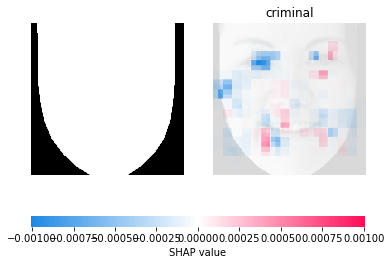

In [26]:
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=['criminal', 'non-criminal'],  # shap_values.output_names,
                true_labels=[''])

### Projector

https://stackoverflow.com/questions/40849116/how-to-use-tensorboard-embedding-projector

In [ ]:
import os
import tensorflow as tf
# import tensorflow_datasets 
from tensorboard.plugins import projector

# Take the labels for each datum in dataset
criminal_train_ds2 = criminal_train_ds.take(2)
labels = np.concatenate([y for x,y in criminal_train_ds2], axis=0)

# Projector
LOG_DIR = log_dir
metadata = os.path.join(LOG_DIR, 'metadata.tsv')

with open(metadata, 'w') as metadata_file:
    for row in labels:
        metadata_file.write('%d\n' % row)

weights = tf.Variable(model.layers[-1].get_weights()[0][1:])
# # Create a checkpoint from embedding, the filename and key are the
# # name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(LOG_DIR, "embedding.ckpt"))

config = projector.ProjectorConfig()
config.embeddings.add()
# One can add multiple embeddings.
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
# Link this tensor to its metadata file (e.g. labels).
embedding.metadata_path = metadata
# Saves a config file that TensorBoard will read during startup.
projector.visualize_embeddings(LOG_DIR, config)

### Test

In [ ]:
from PIL import Image

img_bin = Image.open("./deepcriminalfiles/dataset/little/non-criminal_little/Adrien_Brody_0001.bmp").convert("RGB")
img_arr = np.array(img_bin)
tens = tf.convert_to_tensor(img_arr, dtype=tf.float32)

pred = model.predict(tf.expand_dims(tens, axis=0))
print(pred)

img_bin = Image.open("./deepcriminalfiles/dataset/test/Ray_Lucas_0001.bmp").convert("RGB")
img_arr = np.array(img_bin)
tens = tf.convert_to_tensor(img_arr, dtype=tf.float32)

pred = model.predict(tf.expand_dims(tens, axis=0))
print(pred)

img_bin = Image.open("./deepcriminalfiles/dataset/little/criminal_little/A00147.bmp").convert("RGB")
img_arr = np.array(img_bin)
tens = tf.convert_to_tensor(img_arr, dtype=tf.float32)

pred = model.predict(tf.expand_dims(tens, axis=0))
print(pred)

### Losses

In [ ]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    def contrastive_loss(y_true, y_pred):
    
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean((y_true) * square_pred + (1 - y_true) * margin_square)

    return contrastive_loss

## Model without LocallyConnected

In [ ]:
from deepface import DeepFaceConv

model_conv = DeepFaceConv()
optimizer = tf.keras.optimizers.SGD()
loss = tf.keras.losses.BinaryCrossentropy()
model_conv.compile(optimizer, loss, metrics=['accuracy'])
model_conv.build(input_shape=(4,152,152,3))

In [ ]:
model_conv.summary_model()

In [ ]:
from datetime import datetime
from keras.callbacks import History, EarlyStopping, ModelCheckpoint

history = History()
log_dir = "logs/fit/model_" + datetime.now().strftime("%Y%m%d-%H%M%S") 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)

early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=0, mode='min', restore_best_weights=True)
# mcp_save = ModelCheckpoint('./models/deepface.hdf5', save_best_only=True, monitor='val_loss', mode='min')

callbacks = [history, early_stopping, tensorboard_callback]

In [ ]:
model_conv.fit(criminal_train_ds, validation_data=criminal_val_ds, epochs=100, use_multiprocessing=True, workers=8, callbacks=callbacks)  # .take(20)

## Baseline

#### Linear Classifier

In [ ]:
# imports
from keras.models import Sequential
from keras.layers import Dense, Flatten
from PIL import Image
from datetime import datetime
from keras.callbacks import History, EarlyStopping

# img to test
# img_bin = Image.open("./dataset/aligned/criminals/frame_det_00_000001.bmp").convert("RGB")
# img_arr = np.array(img_bin)
# tens = tf.convert_to_tensor(img_arr, dtype=tf.float32)

# model creation
def create_model():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

lin_class = create_model()
lin_class.compile(optimizer='SGD',
                  metrics=['accuracy'],
                  loss='binary_crossentropy')

lin_class.build(input_shape=(4,152,152,3))
lin_class.summary()

# callbacks
history = History()
log_dir = "logs/fit/linear_model_" + datetime.now().strftime("%Y%m%d-%H%M%S") 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)
early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=0, mode='min', restore_best_weights=True)
callbacks = [history, early_stopping, tensorboard_callback]

# fit
lin_class.fit(criminal_train_ds, validation_data=criminal_val_ds, epochs=100, use_multiprocessing=True, workers=8, callbacks=callbacks)

# predict
# pred = lin_class.predict(tf.expand_dims(tens, axis=0))
# print(pred)

In [ ]:
# imports
from keras.models import Sequential
from keras.layers import Dense, Flatten
from PIL import Image
from datetime import datetime
from keras.callbacks import History, EarlyStopping

# model creation
def create_model():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

lin_class = create_model()
lin_class.compile(optimizer='SGD',
                  metrics=['accuracy'],
                  loss='binary_crossentropy')

lin_class.build(input_shape=(4,152,152,3))
lin_class.summary()

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min', restore_best_weights=True)
callbacks = [early_stopping]

# fit
lin_class.fit(criminal_train_ds.take(100), validation_data=criminal_val_ds.take(20), epochs=10, use_multiprocessing=True, workers=8, callbacks=callbacks)

## TODO

TODO:
- Loss
    - BCE
    - Contrastive
    - Triplette
    - Margin
- Test on third (or forth) set of criminal and non-criminal
- [x] Replace LocallyConnected with normal Conv to see if they do work
- Plot graphs (and maybe embedding space)
- Check distribution of data
- Add baseline
- Insert image of architecture